Problem: Somehow we need a magical tool that is able to predict a person's
health insurance cost just by looking at his/her attributes such as: Age, sex, bmi
and so on. </br> That magical tool can be a ML model and this problem looks just like what an ML model can acquire.

Dataset: We are going to explore and analyse the dataset in a deeper way but now it is a good practice to talk about the general features of the dataset.</br>
There are 7 features of this dataset -including the target attribute-.</br>
These are: Age, sex, bmi, children, smoker, region and finally, charges.</br>

| Attribute | Description |
| --- | --- |
| Age | Age of the person. |
| Bmi | Body mass index of the person. The formula is BMI = (kg / m^2), where kg is the weight of the person in kilograms and m is the height of the person in meters. |
| Children | Number of children covered by health insurance for this person. |
| Smoker | Indicates whether the person is a smoker or not. |
| Region | Person's residential area in the USA. Four possible values: Northeast, Southeast, Southwest, Northwest. |
| Charges | The cost of the person's health insurance. This is the target feature. |


You can find the dataset at this web address: https://www.kaggle.com/datasets/mirichoi0218/insurance</br>

In [1]:
# I used kaggle as development environment,
# And this cell lists the available files in the current dir.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Since we loaded the insurance dataset, it's path must be seen as output

/kaggle/input/insurance/insurance.csv


In [2]:
# Let's store the insurance dataset's path to a variable
insurance_dataset_path = '/kaggle/input/insurance/insurance.csv'

In [3]:
# filterwarnings to remove unnecessary (generally) warnings
from warnings import filterwarnings
filterwarnings('ignore') # ignore the warnings from now on

### Firstly, Let's import the basic data processing modules
import pandas as pd # Data processing, file I/O
import numpy as np  # Linear Algebra

# Seaborn and matplotlib for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Since we have loaded the basic modules,
# Let's now import the pre-processing, model training & performance measuring modules
# Well as I can see, the target variable -charges- is a continous feature.
# So we need regression!

# Data Pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import ensemble
from sklearn import linear_model

# Model Evaluation
from sklearn import metrics

In [5]:
# Let's bring our data in
insurance: pd.DataFrame = pd.read_csv(insurance_dataset_path)

In [6]:
# Let's create a copy of it and keep working with the copy
dataset: pd.DataFrame = insurance.copy()

In [7]:
# Before creating our own plots in our own styles, it is a good practice to use ProfileReport
# This report helps us to see data in a deeper way and assists us to understand how to process this data
from pandas_profiling import ProfileReport
ProfileReport(dataset, title='Insurance Data Profiling Report')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## What can we understand by looking at this report?
#### Structure of the dataset:
1. There are 4 numeric, 2 categorical and 1 boolean type variables,
2. There are 1338 rows -data points- and 7 columns -features-,
3. There is 1 duplicate row,
4. There are no missing cells,

#### Correlations:
When we look at the correlation heatmap or the alerts:
1. Age and smoker is highly correlated -positive- with charges.
2. There is no negative correlation between the charges and the other features,
so there is no feature that decrease the charge value,

## Results
1. We must re-assing the data types of categorical values if they are not type of categorical,
2. We must split the train and test data by 6 - 1 features,
3. We must remove the duplicate row,
4. There is no need to fill in the missing cells since there is no,
5. Remove the features with low correlation to target feature to lower the costs

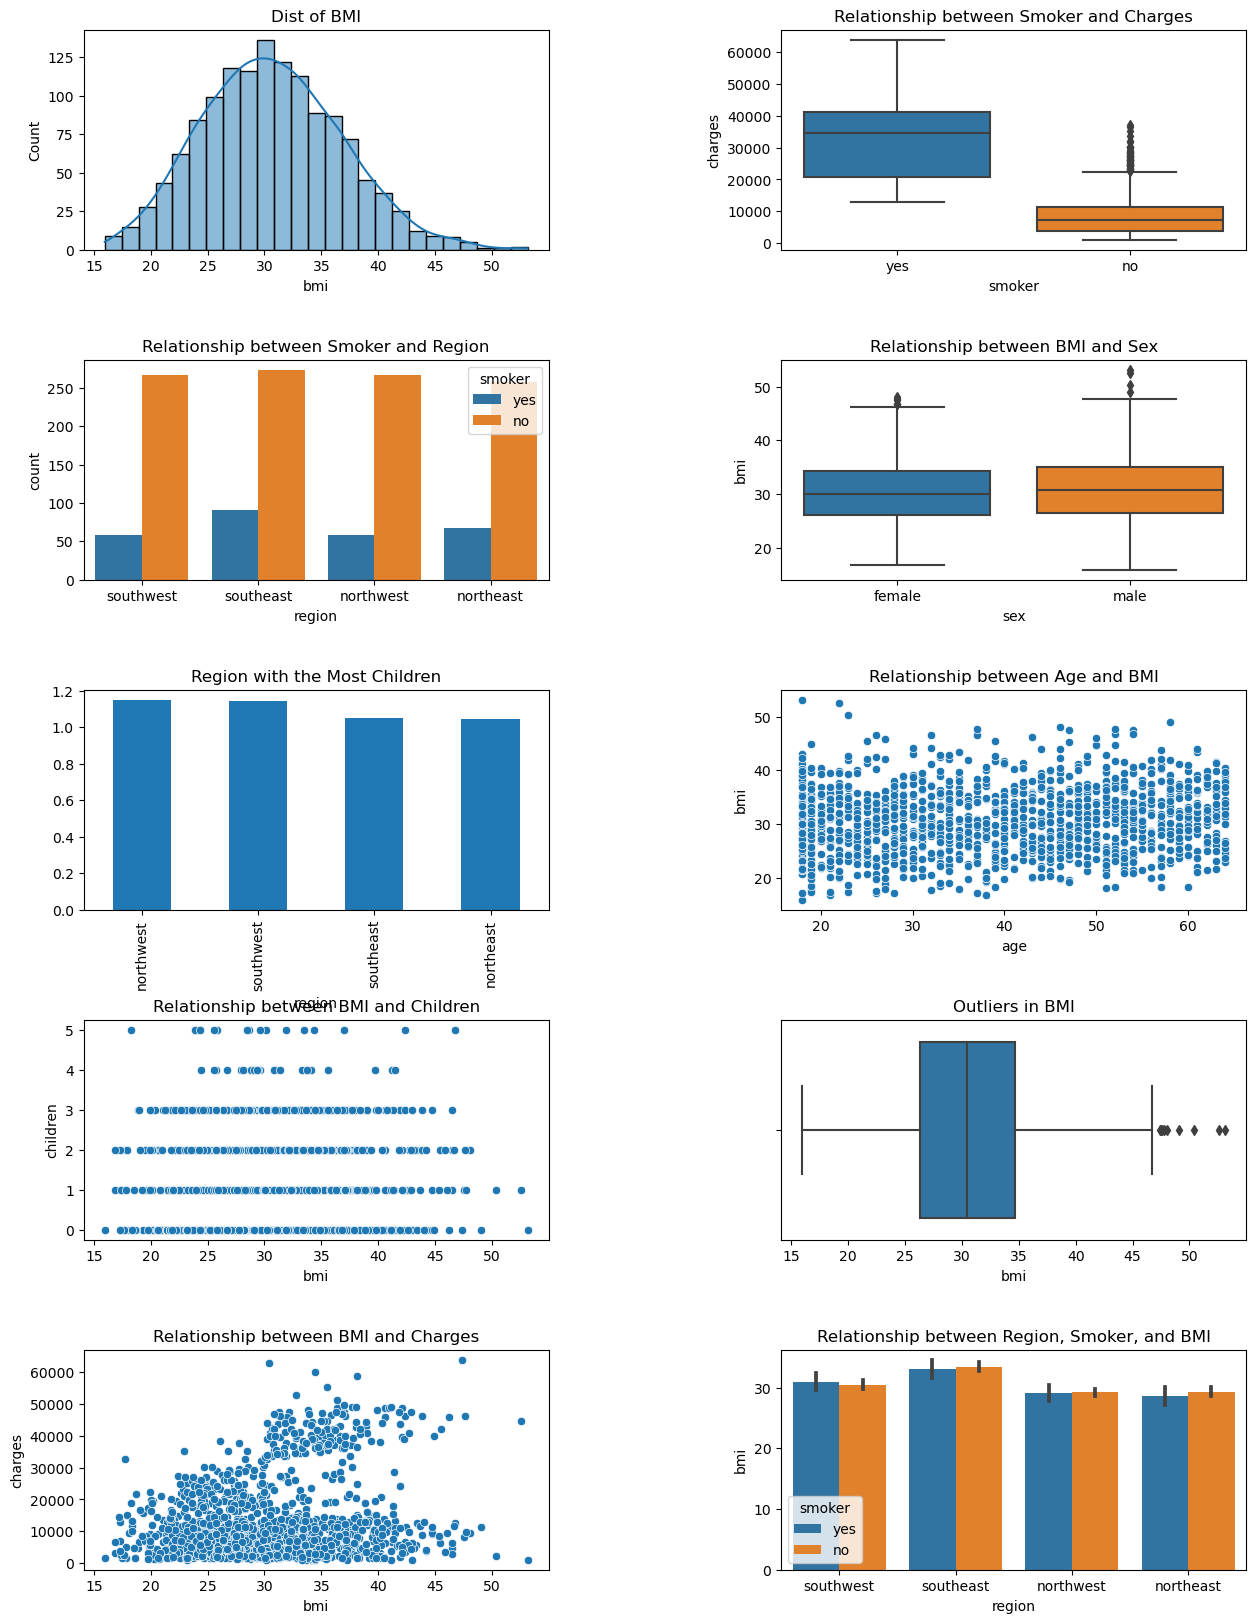

In [8]:
# Let's create the required plots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(wspace=.5, hspace=.5)

# Examine the distribution of Bmi (Body Mass Index)
sns.histplot(dataset['bmi'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Dist of BMI')

# Examine the relationship between “smoker” and “charges”
sns.boxplot(x='smoker', y='charges', data=dataset, ax=axes[0, 1])
axes[0, 1].set_title('Relationship between Smoker and Charges')

# Examine the relationship between “smoker” and “region”.
sns.countplot(x='region', hue='smoker', data=dataset, ax=axes[1, 0])
axes[1, 0].set_title('Relationship between Smoker and Region')

# Examine the relationship between “bmi” and “sex”.
sns.boxplot(x='sex', y='bmi', data=dataset, ax=axes[1, 1])
axes[1, 1].set_title('Relationship between BMI and Sex')

# Find the "region" with the most "children".
region_children = dataset.groupby('region')['children'].mean().sort_values(ascending=False)
region_children.plot(kind='bar', ax=axes[2, 0])
axes[2, 0].set_title('Region with the Most Children')

# Examine the relationship between “age” and “bmi”.
sns.scatterplot(x='age', y='bmi', data=dataset, ax=axes[2, 1])
axes[2, 1].set_title('Relationship between Age and BMI')

# Examine the relationship between “bmi” and “children”.
sns.scatterplot(x='bmi', y='children', data=dataset, ax=axes[3, 0])
axes[3, 0].set_title('Relationship between BMI and Children')

# Is there an outlier in the "bmi" variable? Please review.
sns.boxplot(x='bmi', data=dataset, ax=axes[3, 1])
axes[3, 1].set_title('Outliers in BMI')

# Examine the relationship between “bmi” and “charges”.
sns.scatterplot(x='bmi', y='charges', data=dataset, ax=axes[4, 0])
axes[4, 0].set_title('Relationship between BMI and Charges')

# Examine the relationship between “region”, “smoker” and “bmi” using bar plot.
sns.barplot(x='region', y='bmi', hue='smoker', data=dataset, ax=axes[4, 1])
axes[4, 1].set_title('Relationship between Region, Smoker, and BMI')

plt.show()

### My Inferences
1. BMI is normally distributed,
2. Smokers have higher charges,
3. Southeast has the highest amount of smokers while southwest has the least,
4. As I can see, BMI does not depend on sex,
5. While the northwest has the most children, southeast has the least,
6. I guess there is no certain relation between age and BMI,
7. I guess there is no certain relation between BMI and children,
8. BMI has outliers,
9. There is no certain relation between BMI and Charges,
10. BMI value is slightly more when smoker=no and region is west.

In [9]:
# Let's check the dtypes of our features
pd.DataFrame(dataset.dtypes)

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [10]:
# Sex, Region and Smoker must be categorical. Let's re-assign.
dataset['sex'] = dataset['sex'].astype('category')
dataset['region'] = dataset['region'].astype('category')
dataset['smoker'] = dataset['smoker'].astype('category')
pd.DataFrame(dataset.dtypes)

,0
age,int64
sex,category
bmi,float64
children,int64
smoker,category
region,category
charges,float64


In [11]:
# Let's remove the duplicate row
length_with_duplicates = len(dataset)
dataset = dataset.drop_duplicates()
length_with_duplicates, len(dataset)

(1338, 1337)

In [16]:
# Remove the features with low correlation to target feature
# Remember to save our fully featured dataset to compare feature dropping performance
dataset_light = dataset[['age', 'smoker', 'charges']]

In [17]:
dataset_light.head(7)

,age,smoker,charges
0,19,yes,16884.92400
1,18,no,1725.55230
2,28,no,4449.46200
3,33,no,21984.47061
4,32,no,3866.85520
5,31,no,3756.62160
6,46,no,8240.58960


In [18]:
# Let's convert our categorical values to numerical to let our model to understand our data
dataset_light = pd.get_dummies(dataset_light, columns=['smoker'], prefix=['smoker'])

In [19]:
dataset_light.head(7)

,age,charges,smoker_no,smoker_yes
0,19,16884.92400,0,1
1,18,1725.55230,1,0
2,28,4449.46200,1,0
3,33,21984.47061,1,0
4,32,3866.85520,1,0
5,31,3756.62160,1,0
6,46,8240.58960,1,0


In [20]:
# Let's scale our numeric values to not confuse our model with abnormal numeric differences, yet not the target feature
scaler = StandardScaler()
dataset_light.loc[:, ['age']] = scaler.fit_transform(dataset_light.loc[:, ['age']])
# Now we have normalized our data to be inside the same ranges

In [21]:
dataset_light.head(7)

,age,charges,smoker_no,smoker_yes
0,-1.440418,16884.92400,0,1
1,-1.511647,1725.55230,1,0
2,-0.799350,4449.46200,1,0
3,-0.443201,21984.47061,1,0
4,-0.514431,3866.85520,1,0
5,-0.585661,3756.62160,1,0
6,0.482785,8240.58960,1,0


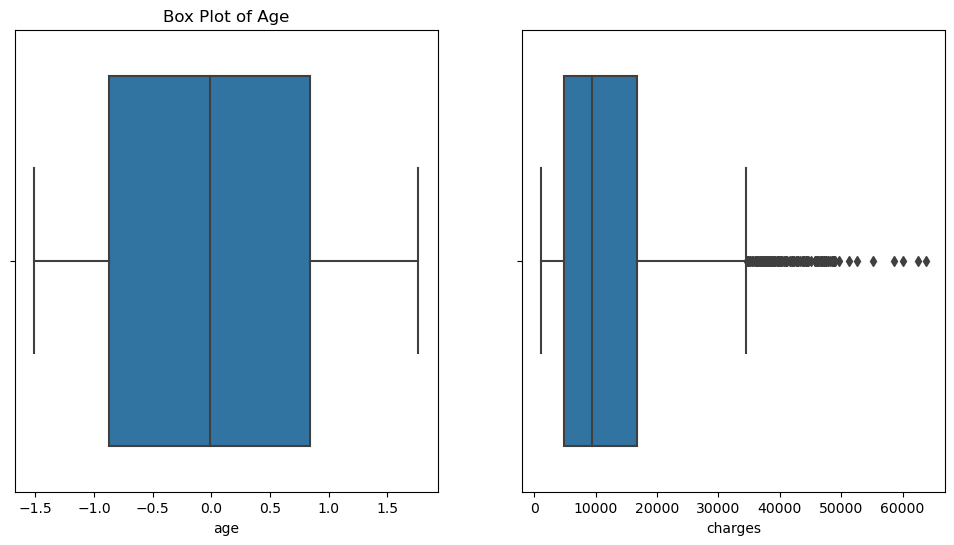

In [22]:
# What we did not visualize in our previous data exploration is the outliers
# Let's see if there are any outliers thanks to box plots

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=dataset_light['age'])
plt.title('Box Plot of Age')

plt.subplot(1, 2, 2)
sns.boxplot(x=dataset_light['charges'])

plt.show()

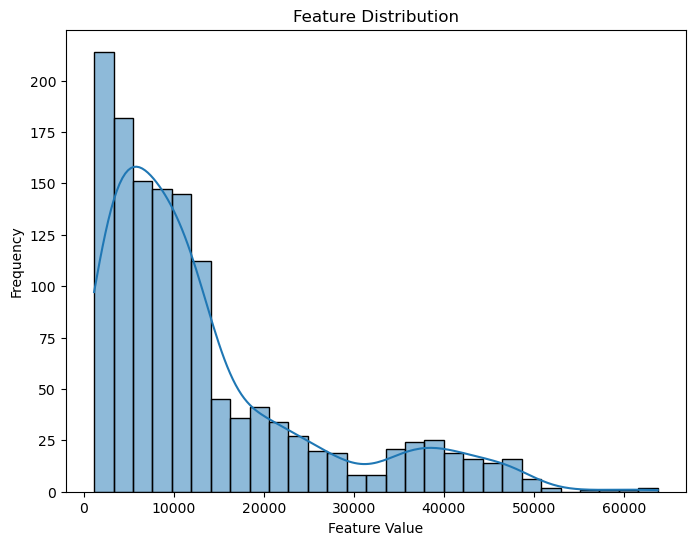

In [23]:
# We can see that there are many outliers in the charges feature,
# Yet that might be fitting the real world scenario,
# Let's see if they form a acceptable bell graph

plt.figure(figsize=(8, 6))
sns.histplot(dataset_light['charges'], kde=True)
plt.title('Feature Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Well it really does not form a perfect bell graph,
# As I know, the natural distribution is eager to form a bell graph.
# So let's clean our data with removing the outliers.
# I have chosen the threshold Z score as [-0.9, 0.9]

z_scores = np.abs((dataset_light['charges'] - dataset_light['charges'].mean()) / dataset_light['charges'].std())
lower_bound, upper_bound = -0.9, 0.9
dataset_light = dataset_light[(z_scores >= lower_bound) & (z_scores <= upper_bound)]

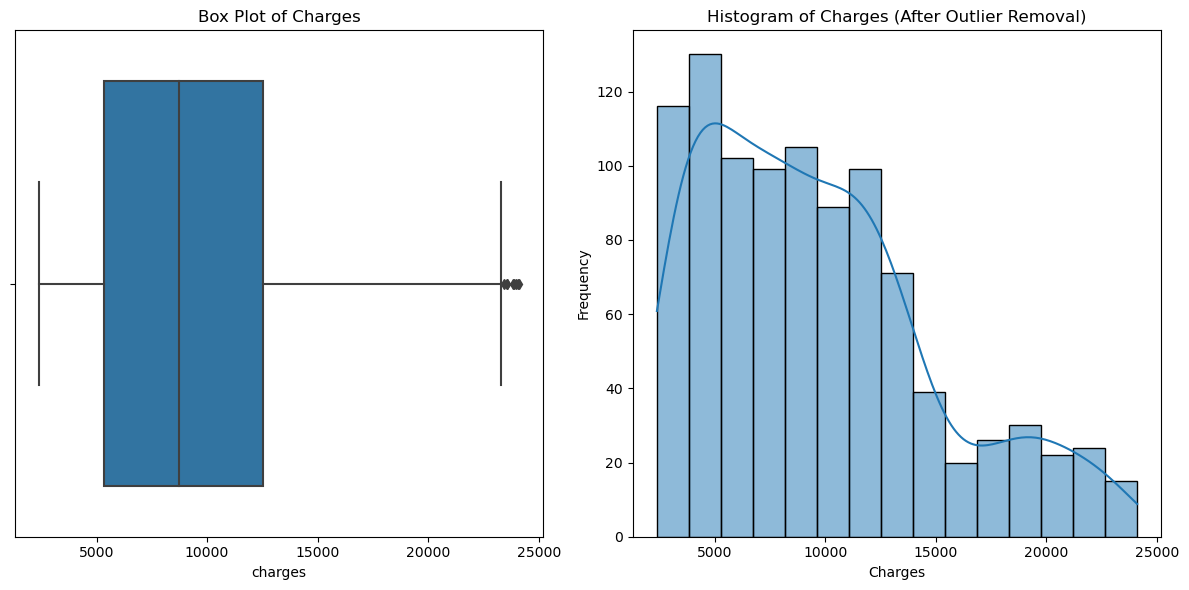

(987, 4)

In [25]:
# Now let's plot the box and histogram again to check if we got rid of outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=dataset_light['charges'])
plt.title('Box Plot of Charges')

plt.subplot(1, 2, 2)
sns.histplot(x=dataset_light['charges'], kde=True)
plt.title('Histogram of Charges (After Outlier Removal)')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
dataset_light.shape

In [26]:
# Now since we solved the outlier problems too,
# Let's build our model

# Let's split our data into features and target
X = dataset_light.drop('charges', axis=1)
y = dataset_light.loc[:, 'charges']

# I have chosen the random_state=42 because 42 is the Answer to the Ultimate Question of Life, the Universe, and Everything.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Let's train our model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred = model.predict(X_test)

In [29]:
# I like to calculate rmse instead of mse since I can interpret this metric more easily
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

In [30]:
rmse, np.mean(y_test)

(3271.2479622487463, 9367.92748540404)

In [31]:
# Since our rmse is 3271, our model is predicting the cost of health insurances with 3271 dollar mistake margin.
# We can say that this amount of mistake is acceptable for a feature with mean of 9367 dollars.
# But this correctness depends on the scenario and it is not that good.

In [32]:
# Now let's try another model, RandomForestRegressor
model = ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
y_pred = model.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

In [34]:
rmse

3214.5411486880516

In [35]:
# We got a better result than the LinearRegression
# Let's pick random forest as our model and tune it's hyperparameters

In [36]:
random_forest = ensemble.RandomForestRegressor(random_state=42)

# Grid Search
hyperparams_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20],            # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=hyperparams_grid,\
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
rmse_best = metrics.mean_squared_error(y_test, y_pred_best, squared=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [37]:
best_params, best_rf, rmse_best

({'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 200},
 RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42),
 3144.3562869007255)

In [38]:
# So our best result for rmse score is 3144.

In [39]:
# Now, it is a good time to see if we made a mistake by reducing the features
# Remember our dataset?
dataset.head(7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960


In [40]:
# Let's scale our numeric features again, except the target feature
scaler = StandardScaler()
dataset.loc[:, ['age', 'bmi', 'children']] = scaler.fit_transform(dataset.loc[:, ['age', 'bmi', 'children']])
# Now we have normalized our data to be inside the same ranges

In [41]:
# Now one hot encode the categorical features
dataset = pd.get_dummies(dataset, columns=['sex', 'smoker', 'region'], prefix=['sex', 'smoker', 'region'])

In [42]:
dataset.head(7)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.453160,-0.909234,16884.92400,1,0,0,1,0,0,0,1
1,-1.511647,0.509422,-0.079442,1725.55230,0,1,1,0,0,0,1,0
2,-0.799350,0.383155,1.580143,4449.46200,0,1,1,0,0,0,1,0
3,-0.443201,-1.305052,-0.909234,21984.47061,0,1,1,0,0,1,0,0
4,-0.514431,-0.292456,-0.909234,3866.85520,0,1,1,0,0,1,0,0
5,-0.585661,-0.807363,-0.909234,3756.62160,1,0,1,0,0,0,1,0
6,0.482785,0.455307,-0.079442,8240.58960,1,0,1,0,0,0,1,0


In [43]:
# Let's remove the outliers in the same way again
# I won't plot the box plots again since we plotted them before
z_scores = np.abs((dataset['charges'] - dataset['charges'].mean()) / dataset['charges'].std())
# Let's take the ranges wider than the previous one
lower_bound, upper_bound = -2, 2
dataset = dataset[(z_scores >= lower_bound) & (z_scores <= upper_bound)]


In [44]:
dataset.shape

(1230, 12)

In [45]:
# Let's remove the outliers in the same way again
# I won't plot the box plots again since we plotted them before
z_scores = np.abs((dataset['bmi'] - dataset['bmi'].mean()) / dataset['bmi'].std())
lower_bound, upper_bound = -2, 2
dataset = dataset[(z_scores >= lower_bound) & (z_scores <= upper_bound)]


In [46]:
dataset.shape

(1180, 12)

In [47]:
# Now since we have more data points than previous attempt, we may have a better result
# split the dataset into train and test
X = dataset.drop('charges', axis=1)
y = dataset.loc[:, 'charges']

# I have chosen the random_state=42 because 42 is the Answer to the Ultimate Question of Life, the Universe, and Everything.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Let's use RandomForestRegressor again, but this time I'll find the best parameters & score directly

In [48]:
random_forest = ensemble.RandomForestRegressor(random_state=42)

# Grid Search
hyperparams_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20],            # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=hyperparams_grid,\
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
rmse_best = metrics.mean_squared_error(y_test, y_pred_best, squared=False)

In [50]:
best_params, best_rf, rmse_best

({'max_depth': None,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 200},
 RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42),
 4426.640945671987)

#### This time the rmse is 4426, lower than the previous score (3144).
#### There might be several reasons for this -my interpretation, so it might not be accurate-.
1. I have dropped the features with low correlation to target feature. This action decreased the complexity of our data. <br>
So our regression model dealed with less data and this led our model to be more accurate.
2. I have used a more narrow Z-Score range in the previous attempt. So this might make our data more realistic -remember the normal distribution, bell graph-.

In [ ]:
# Thanks a lot for spending time reading my notebook. I had a limited amount of time to create this -a few hours- yet tried my best.
# I took some actions which were not in the instructions -see MedicalCostAnalysis.pdf- but did that with a good intention and tried to make some experiments.
# Again, thanks a lot for the bootcamp and this well-prepared project.
# Metin KONUK